# Cardiovascular Disease Detection (EDA, Decision Tree, Random Forest)

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_style('white')

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import (
    zero_one_loss, 
    accuracy_score, 
    f1_score,
    confusion_matrix, 
    ConfusionMatrixDisplay, 
    classification_report
)

import warnings
warnings.filterwarnings('ignore')

# Download and Explore the Data

In [4]:
# Loading the dataframe
disease_df = pd.read_csv('cardio_train.csv',
                         sep = ';', index_col = False).iloc[:, 1:]
disease_df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [5]:
# Size of the dataset
disease_df.shape

(70000, 12)

In [6]:
disease_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          70000 non-null  int64  
 1   gender       70000 non-null  int64  
 2   height       70000 non-null  int64  
 3   weight       70000 non-null  float64
 4   ap_hi        70000 non-null  int64  
 5   ap_lo        70000 non-null  int64  
 6   cholesterol  70000 non-null  int64  
 7   gluc         70000 non-null  int64  
 8   smoke        70000 non-null  int64  
 9   alco         70000 non-null  int64  
 10  active       70000 non-null  int64  
 11  cardio       70000 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 6.4 MB


In [7]:
disease_df.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
disease_df.nunique()

age            8076
gender            2
height          109
weight          287
ap_hi           153
ap_lo           157
cholesterol       3
gluc              3
smoke             2
alco              2
active            2
cardio            2
dtype: int64

# Exploratory Data Analysis (EDA)

The original dataset is already ordinally encoded. But for interpretation purposes during visualization, I created a new dataframe, in which ordinal numbers were replaced with corresponding categorical values.

In [9]:
viz_df = disease_df.copy(deep = True)

viz_df['age'] = (viz_df['age'] / 365).round().astype('int')
viz_df['gender'].replace({1: 'woman', 2: 'man'}, inplace = True)
viz_df['cholesterol'].replace({1: 'normal', 2: 'above normal', 3: 'well above normal'}, inplace = True)
viz_df['gluc'].replace({1: 'normal', 2: 'above normal', 3: 'well above normal'}, inplace = True)
viz_df['smoke'].replace({0: 'No', 1: 'Yes'}, inplace = True)
viz_df['alco'].replace({0: 'No', 1: 'Yes'}, inplace = True)
viz_df['active'].replace({0: 'No', 1: 'Yes'}, inplace = True)
viz_df['cardio'].replace({0: 'No', 1: 'Yes'}, inplace = True)

viz_df.head(10)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,50,man,168,62.0,110,80,normal,normal,No,No,Yes,No
1,55,woman,156,85.0,140,90,well above normal,normal,No,No,Yes,Yes
2,52,woman,165,64.0,130,70,well above normal,normal,No,No,No,Yes
3,48,man,169,82.0,150,100,normal,normal,No,No,Yes,Yes
4,48,woman,156,56.0,100,60,normal,normal,No,No,No,No
5,60,woman,151,67.0,120,80,above normal,above normal,No,No,No,No
6,61,woman,157,93.0,130,80,well above normal,normal,No,No,Yes,No
7,62,man,178,95.0,130,90,well above normal,well above normal,No,No,Yes,Yes
8,48,woman,158,71.0,110,70,normal,normal,No,No,Yes,No
9,54,woman,164,68.0,110,60,normal,normal,No,No,No,No


In [10]:
# Separating numeric and categorical columns
numeric_cols = viz_df.select_dtypes(include = np.number).columns.tolist()
print("Numerical Columns:", numeric_cols)

categorical_cols = viz_df.select_dtypes(include = 'object').columns.tolist()
print("Categorical Columns:", categorical_cols)

Numerical Columns: ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
Categorical Columns: ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio']


## Numeric Columns



**`ap_hi`** & **`ap_li`**

> Systolic pressure below 90 mmHg is considered low and may require intervention and management from your healthcare provider. If you get multiple systolic pressure readings above 180 mmHg, it is considered dangerously high and should be addressed by your healthcare provider. _[Reference: Systolic vs. Diastolic Blood Pressure](https://www.verywellhealth.com/systolic-and-diastolic-blood-pressure-1746075)_

With that information above, we may need to drop the data whose systolic pressure (`ap_hi`) are lower than 90 and higher than 200. But first, we need know how much of the dataset is affected by that information.

In [11]:
# The percentage of data with systolic pressure below 70 and above 200
bad_aphi = (viz_df.ap_hi < 70) | (viz_df.ap_hi > 200)
viz_df[bad_aphi].ap_hi.count() / viz_df.ap_hi.count()

0.0041285714285714285

Since only 0.4% of the data is affected, we can safely remove those data.



In [12]:
viz_df.drop(viz_df[bad_aphi].index, inplace = True)

viz_df[bad_aphi].ap_hi.count() / viz_df.ap_hi.count()

0.0

> Normal diastolic blood pressure during quiet rest is below 80 mmHg.1 If you have high blood pressure, the diastolic number is often higher even during quiet rest. Diastolic blood pressure is considered dangerously low when it is 60 mmHg or lower and dangerously high when it is 110 mmHg or over. _[Reference: Systolic vs. Diastolic Blood Pressure](https://www.verywellhealth.com/systolic-and-diastolic-blood-pressure-1746075)_

In [13]:
# The percentage of data with diastolic pressure below 60 and above 110
bad_aplo = (viz_df.ap_lo < 40) | (viz_df.ap_lo > 130) 
viz_df[bad_aplo].ap_lo.count() / viz_df.ap_lo.count()

0.014947425800806186

Since only 1.5% of the data is affected, we can safely remove those data.

In [14]:
viz_df.drop(viz_df[bad_aplo].index, inplace = True)

viz_df[bad_aplo].ap_lo.count() / viz_df.ap_lo.count()

0.0

In [15]:
disease_df.drop(disease_df[(disease_df.ap_hi < 70) | (disease_df.ap_hi > 200)].index, inplace = True)
disease_df.drop(disease_df[(disease_df.ap_lo < 40) | (disease_df.ap_lo > 130)].index, inplace = True)

In [16]:
disease_df.drop(disease_df[(disease_df.ap_hi < 70) | (disease_df.ap_hi > 200)].index, inplace = True)
disease_df.drop(disease_df[(disease_df.ap_lo < 40) | (disease_df.ap_lo > 130)].index, inplace = True)

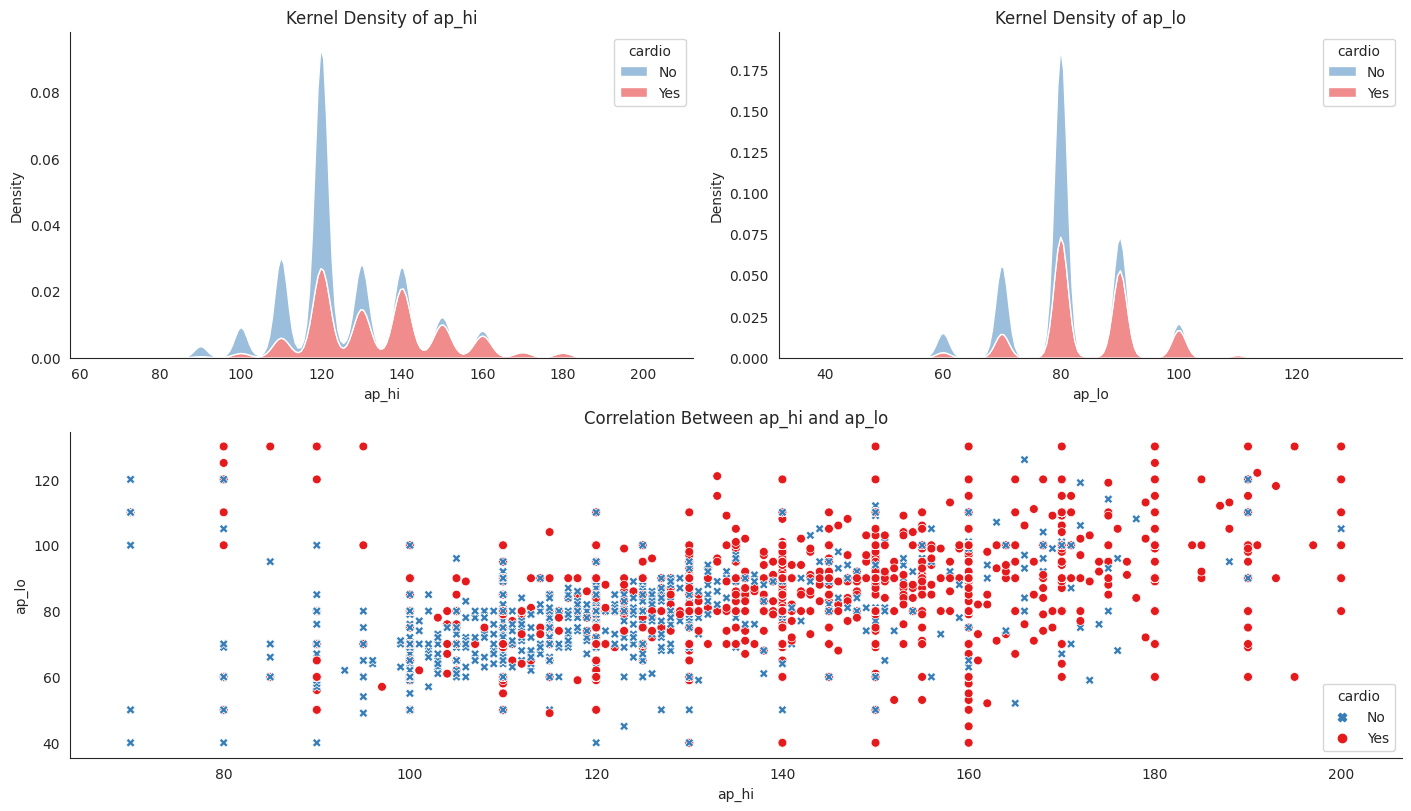

In [17]:
# Visualizing ap_hi and ap_lo
fig = plt.figure(figsize = (14, 8), constrained_layout = True)
gs = fig.add_gridspec(2, 4)
plt.subplots_adjust(hspace = 0.4, wspace = 0.5)
palette = {'No': '#377EB8', 'Yes': '#E41A1C'}

# Density of ap_hi
ax1 = fig.add_subplot(gs[0, :2])
ax1 = sns.kdeplot(data = viz_df, x = 'ap_hi', hue = 'cardio', palette = palette, alpha = 0.5, multiple = 'stack')
ax1.set_title('Kernel Density of ap_hi')

# Density of ap_lo
ax2 = fig.add_subplot(gs[0, 2:])
ax2 = sns.kdeplot(data = viz_df, x = 'ap_lo', hue = 'cardio', palette = palette, alpha = 0.5, multiple = 'stack')
ax2.set_title('Kernel Density of ap_lo')

# Scatter plot to observe correlation between ap_hi and ap_lo
ax3 = fig.add_subplot(gs[1, :])
ax3 = sns.scatterplot(data = viz_df, x = 'ap_hi', y = 'ap_lo', hue = 'cardio', palette = palette, 
                style = 'cardio', markers = {'No': 'X', 'Yes': 'o'}, s = 40)
ax3.set_title('Correlation Between ap_hi and ap_lo')

sns.despine();

Learning from the scatterplot above, if you have cardiovascular disease, your `ap_hi` and `ap_lo` tend to be higer. Also, the plot clearly indicates that there is a linear correlation between `ap_hi` and `ap_lo`.

In [18]:
viz_df['ap_hi'].corr(viz_df['ap_lo'])

0.7128698197954739

The correlation coefficient between `ap_hi` and `ap_lo` is 0.7128. We can also find the probability of getting cardiovascular disease when you meet these two conditions.

In [19]:
mean_aphi = viz_df['ap_hi'].mean()
mean_aplo = viz_df['ap_lo'].mean()

cardio_count = viz_df[(viz_df['ap_hi'] > mean_aphi) & (viz_df['ap_lo'] > mean_aplo)].cardio.value_counts()
cardio_count / cardio_count.sum()

Yes    0.798682
No     0.201318
Name: cardio, dtype: float64

The probability of getting disease if you have higher `ap_hi` and `ap_lo` is 0.7987.

**Observing Linear Relationships between Independent Variables**

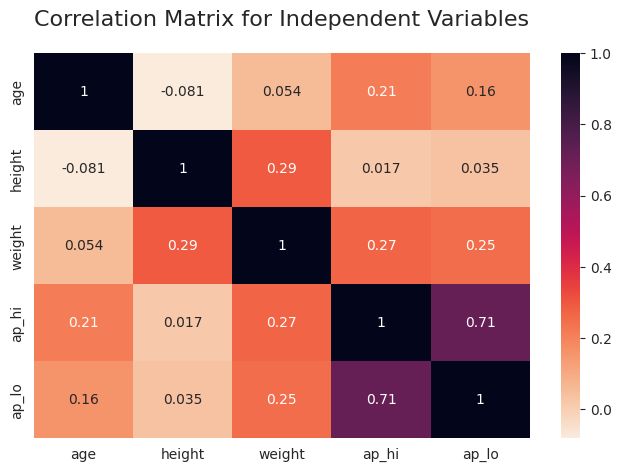

In [20]:
# heatmap for correlation
plt.figure(figsize = (8, 5))
plt.title('Correlation Matrix for Independent Variables', fontsize = 16, y = 1.05)

sns.heatmap(viz_df[numeric_cols].corr(), annot = True, cmap = 'rocket_r');

Learning from the heatmap above, the linear correlation only seems to be the case for `ap_hi` and `ap_lo`. But we can also learn more about how `weight` is correlated with `ap_hi` and `ap_lo` since their coorelation is a little bit higher than that of other variables.

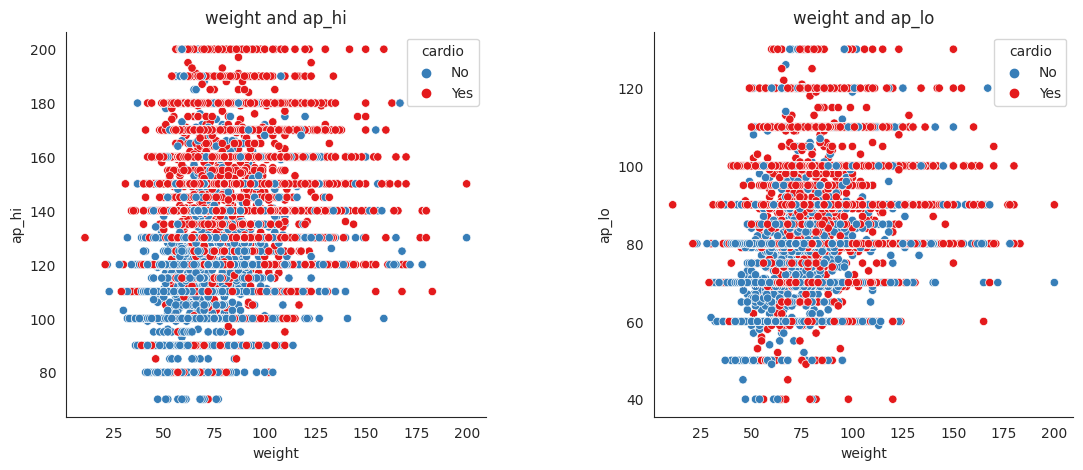

In [21]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (13, 5))
plt.subplots_adjust(wspace = 0.4)

ax1 = sns.scatterplot(data = viz_df, x = 'weight', y = 'ap_hi', hue = 'cardio', palette = palette, ax = axes.flat[0])
ax1.set_title('weight and ap_hi')

ax2 = sns.scatterplot(data = viz_df, x = 'weight', y = 'ap_lo', hue = 'cardio', palette = palette, ax = axes.flat[1])
ax2.set_title('weight and ap_lo')

sns.despine();

It is clear that a major of people who have cardiovascular disease weigh more and have higher `ap_hi` and `ap_lo`.

In [22]:
mean_weight = viz_df['weight'].mean()
weight_and_aphi = viz_df[(viz_df['weight'] > mean_weight) & (viz_df['ap_hi'] > mean_aphi)].cardio.value_counts()
weight_and_aplo = viz_df[(viz_df['weight'] > mean_weight) & (viz_df['ap_lo'] > mean_aplo)].cardio.value_counts()
weight_aphi_aplo = viz_df[(viz_df['weight'] > mean_weight) & (viz_df['ap_hi'] > mean_aphi) & (viz_df['ap_lo'] > mean_aplo)].cardio.value_counts()

print('For people who weigh more and have higher ap_hi:')
print(weight_and_aphi / weight_and_aphi.sum())
print('---------------------------------------\n')

print('For people who weigh more and have higher ap_lo:')
print(weight_and_aplo / weight_and_aplo.sum())
print('---------------------------------------\n')

print('For people who weigh more as well as have higher ap_hi and ap_lo:')
print(weight_aphi_aplo / weight_aphi_aplo.sum())

For people who weigh more and have higher ap_hi:
Yes    0.766669
No     0.233331
Name: cardio, dtype: float64
---------------------------------------

For people who weigh more and have higher ap_lo:
Yes    0.779825
No     0.220175
Name: cardio, dtype: float64
---------------------------------------

For people who weigh more as well as have higher ap_hi and ap_lo:
Yes    0.803752
No     0.196248
Name: cardio, dtype: float64


**`Age`**

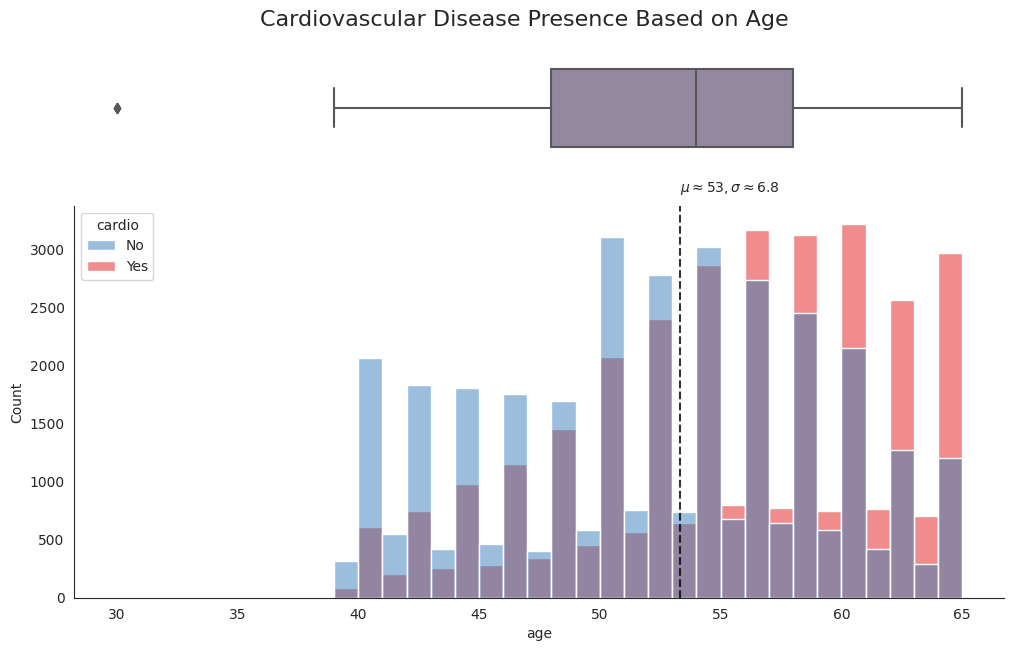

In [23]:
# Visualizing Cardiovascular Disease Presence Based on Age
fig, axes = plt.subplots(2, 1, figsize = (12, 7), sharex = True, gridspec_kw = {'height_ratios': [1, 4]})
fig.suptitle('Cardiovascular Disease Presence Based on Age', fontsize = 16, y = 0.95)

# Boxplot 
sns.boxplot(data = viz_df, x = 'age', ax = axes.flat[0], color = '#9384A2')
axes[0].set(xlabel = None)
sns.despine(bottom = True, left = True, ax = axes.flat[0])

# Histogram Plot Based on Age
sns.histplot(data = viz_df, x = 'age', hue = 'cardio', binwidth = 1, palette = palette, stat = 'count', alpha = 0.5, ax = axes.flat[1])
plt.axvline(x = viz_df.age.mean(), color = 'black', linestyle = '--', alpha = 0.8)
plt.text(x = viz_df['age'].mean(), y = 3500, s = r'$\mu \approx 53, \sigma \approx 6.8$')
sns.despine(ax = axes.flat[1])

One thing strange (or maybe weird) about this dataset is that the number of people with odd number (age) is significantly lower than that with even number (age). But in general, we can conclude that the chance of getting cardiovascular disease becomes larger as you get older.

In [24]:
mean_age = round(viz_df['age'].mean())
print('Average age:', mean_age)

cardio_count = viz_df[(viz_df['age'] > mean_age) | (viz_df['age'] == mean_age)].cardio.value_counts()

print('\nIf your age is', mean_age, 'or above', mean_age)
print(cardio_count / cardio_count.sum())

Average age: 53

If your age is 53 or above 53
Yes    0.579921
No     0.420079
Name: cardio, dtype: float64


**`Height`** & **`Weight`**

In [25]:
"""
1. Based on weight and height, calculate the number of people who has disease and who doesn't.
   Since there are four possible combinations of weight and height, we get four values, each of which has corresponding 'No' and 'Yes' 
   to report the disease presence.
2. Then, for each combination, we calculate the total number of people (refers to `totals` list). And with that value, we calculate
   the percentage of people who have disease and who don't for that set of combination.
3. Store the resulting percentages to `percent_df` in order for visualization purposes. Each index represents a quadrant in the plane.
"""
big_height = viz_df.height > viz_df.height.mean()
small_height = viz_df.height < viz_df.height.mean()
big_weight = viz_df.weight > viz_df.weight.mean()
small_weight = viz_df.weight < viz_df.weight.mean()

sh_bw = viz_df[small_height & big_weight].groupby('cardio').cardio.count() # Quadrant 1 -> Small Height, Big Weight
bh_bw = viz_df[big_height & big_weight].groupby('cardio').cardio.count() # Quadrant 2 -> Big Height, Big Weight
bh_sw = viz_df[big_height & small_weight].groupby('cardio').cardio.count() # Quadrant 3 -> Big Height, Small Weight
sh_sw = viz_df[small_height & small_weight].groupby('cardio').cardio.count() # Quadrant 4 -> Small Height, Small Weight

names = [sh_bw, bh_bw, bh_sw, sh_sw]
totals = [name.sum() for name in names]

percent_df = pd.DataFrame([(name/ total).values for name, total in zip(names, totals)], columns = ['No', 'Yes'])
percent_df

,No,Yes
0,0.384654,0.615346
1,0.441930,0.558070
2,0.584917,0.415083
3,0.560423,0.439577


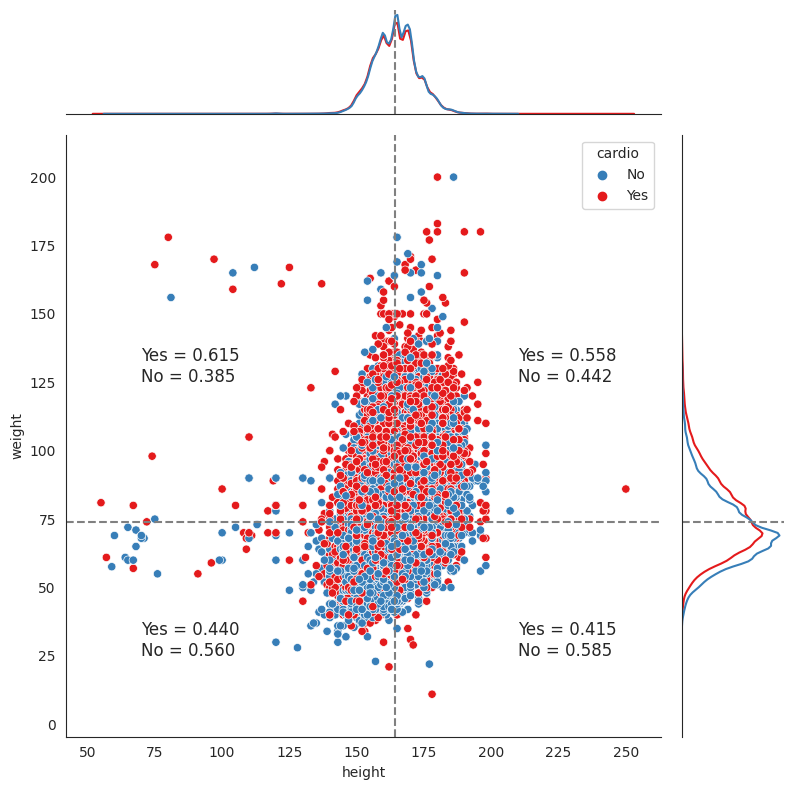

In [26]:
# The horizontal and vertical lines represent the mean values of the corresponding variables.
g = sns.JointGrid(data = viz_df, x = 'height', y = 'weight', hue = 'cardio', palette = palette, height = 8)
g.plot_joint(sns.scatterplot)
g.plot_marginals(sns.kdeplot)
g.refline(x = viz_df.height.mean(), y = viz_df.weight.mean())

# Annotation
def annotate(q, x, y):
  g.ax_joint.annotate(f"Yes = {percent_df.Yes[q]:.3f}\nNo = {percent_df.No[q]:.3f}", 
                      fontsize = 12, xy = (x, y)); # bbox = {'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'}
  pass
  
annotate(0, 70, 125) # Quadrant 1 -> Small Height, Big Weight
annotate(1, 210, 125) # Quadrant 2 -> Big Height, Big Weight
annotate(2, 210, 25) # Quadrant 3 -> Big Height, Small Weight
annotate(3, 70, 25) # Quadrant 4 -> Small Height, Small Weight

We can learn from the above plot that the people who weigh more are likely to get cardiovascular disease regardless of their heights. But the chance is higher if you're short (Among the four quadrants in the plot, the difference between "Yes (0.621)" and "No (0.379)" in that one is highest with 24.2%. So, we can conclude that in detecting the disease presence, 'weight' is a more important factor than 'height.'

## Categorical Columns

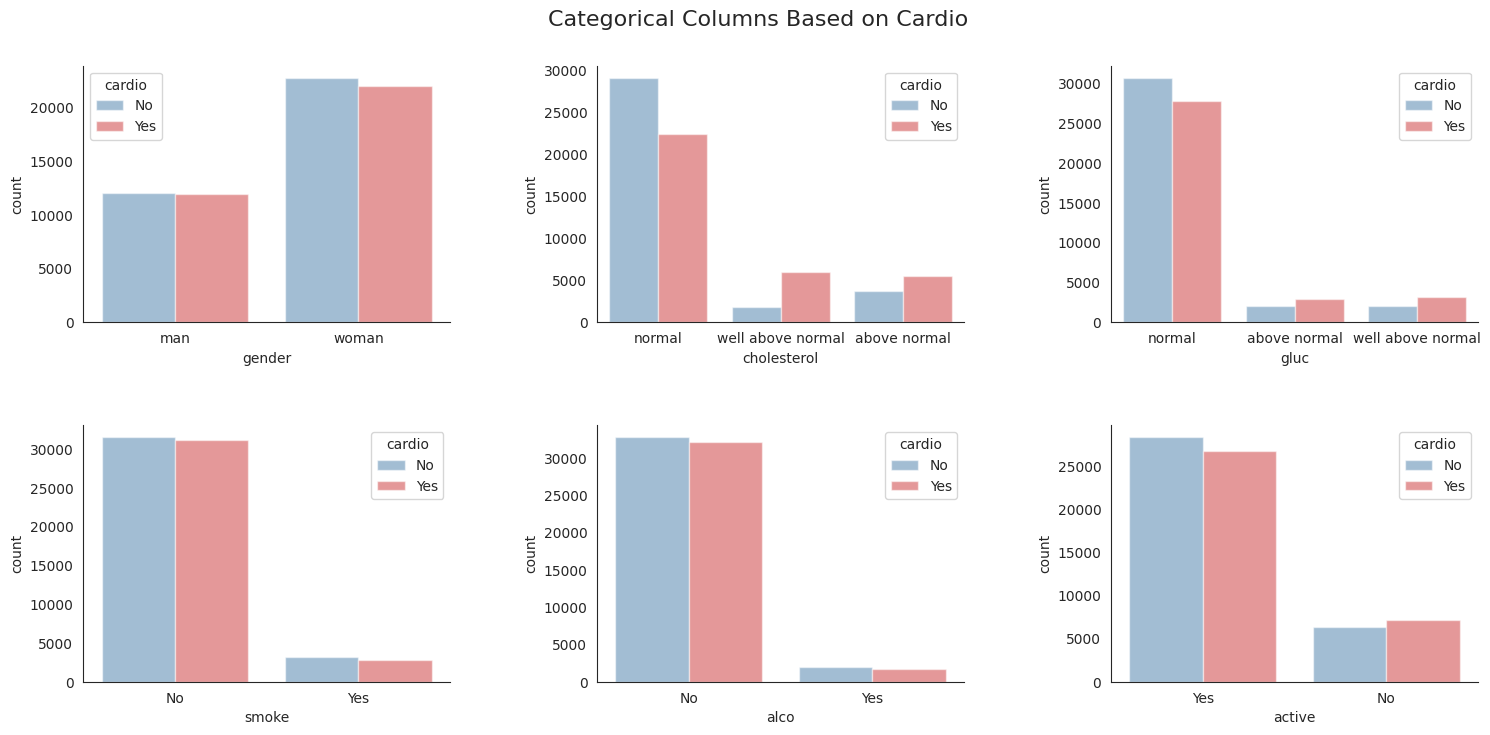

In [27]:
# Categorical Columns Based on Age
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (18, 8))

fig.suptitle('Categorical Columns Based on Cardio', y = 0.95, fontsize = 16)
plt.subplots_adjust(hspace = 0.4, wspace = 0.4)

for pos, name in enumerate(categorical_cols[:-1]):
  sns.countplot(data = viz_df, x = name, hue = 'cardio', ax = axes.flat[pos], palette = palette, alpha = 0.5);

sns.despine()

In [28]:
print("Gender Ratio (in Percentage):")
print(round(viz_df.gender.value_counts() / viz_df.gender.count() * 100, 2))
print("---------------------------------------\n")

print("Cardiovascular Disease Presence in Men and Women (in Percentage):")
print(round(viz_df.groupby('gender')['cardio'].value_counts() / viz_df.groupby('gender')['cardio'].count() * 100, 2))

Gender Ratio (in Percentage):
woman    65.14
man      34.86
Name: gender, dtype: float64
---------------------------------------

Cardiovascular Disease Presence in Men and Women (in Percentage):
gender  cardio
man     No        50.09
        Yes       49.91
woman   No        50.81
        Yes       49.19
Name: cardio, dtype: float64


About 65% of the dataset represents 'woman', whereas the rest 35% does 'man'. But the number of people who have disease and the number of people who don't have disease are almost equal in both genders.

# Preparing the Data for the Model

In [29]:
X = disease_df.iloc[:, :-1]
y = disease_df.iloc[:, -1:].values

print('inputs_df size:', X.shape)
print('output_df size:', y.shape)
print('Missing data check:', 'No missing data' if X.isnull().sum().sum() == 0 else X.isnull().sum().sum())

inputs_df size: (68669, 11)
output_df size: (68669, 1)
Missing data check: No missing data


In [30]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.25, random_state = 42)

print('Training dataset size:', X_train.shape)
print('Validation dataset size:', X_val.shape)

Training dataset size: (51501, 11)
Validation dataset size: (17168, 11)


### Scaling

In [31]:
scaler = MinMaxScaler().fit(X_train[numeric_cols])
X_train[numeric_cols] = scaler.transform(X_train[numeric_cols])
X_val[numeric_cols] = scaler.transform(X_val[numeric_cols])

Since the data is already ordinally encoded, we can skip the encoding step.

# Training the Model using Different Algorithms

To train the model, we will use these three algorithms: `DecisionTreeClassifier`, `RandomForestClassifier`, and `AdaBoostClassifier`. First of all, we will take a look at how these three algorithms perform on the data without optimization.

In [32]:
classifiers = [DecisionTreeClassifier(random_state = 41), 
               RandomForestClassifier(random_state = 41), 
               AdaBoostClassifier(random_state = 41)]

def train_model(classifier):
  model = classifier.fit(X_train, y_train)
  train_pred = model.predict(X_train)
  val_pred = model.predict(X_val)

  val_accuracy = round(accuracy_score(y_val, val_pred), 4)
  loss = round(zero_one_loss(y_val, val_pred), 4)
  f1 = round(f1_score(y_val, val_pred, average = 'binary'), 4)

  return str(classifier), val_accuracy, loss, f1
  
base_df = pd.DataFrame([train_model(classifier) for classifier in classifiers], 
                       columns = ['Model', 'Validation Accuracy', 'Zero-One Loss', 'F1 Score'])
base_df

,Model,Validation Accuracy,Zero-One Loss,F1 Score
0,DecisionTreeClassifier(random_state=41),0.6344,0.3656,0.6309
1,RandomForestClassifier(random_state=41),0.7164,0.2836,0.7101
2,AdaBoostClassifier(random_state=41),0.7300,0.2700,0.7072


It is obvious that `AdaBoostClassifier` does the best job of predicting the class among these three. Now, we will optimize each model using relevant parameters. But first of all, we will define helper functions.

In [33]:
results_df = pd.DataFrame(columns = ['Model', 'Validation Accuracy', 'Zero-One Loss', 'F1 Score'])

'''
 The following function is used for calculating and printing the results 
 after training each model with the best hyperparameters chosen.
 It also appends the results to the `results_df` for future comparison.
'''
def print_and_append(model, y_val, val_pred):
  val_accuracy = round(accuracy_score(y_val, val_pred), 4)
  loss = round(zero_one_loss(y_val, val_pred), 4)
  f1 = round(f1_score(y_val, val_pred), 4)

  print('Validation accuracy:', val_accuracy)
  print('Zero-One Loss:', loss)
  print('F1 Score:', f1)
  
  global results_df
  results_df = results_df.append({
    'Model': model,
    'Validation Accuracy': val_accuracy,
    'Zero-One Loss': loss,
    'F1 Score': f1}, ignore_index = True)

# Classification Report and Confusion Matrix
def cr_and_cm(model, y_val, val_pred):
  print('\nClassification Report and Confusion Matrix')
  print('------------------------------------------')
  print(classification_report(y_val, val_pred))
  
  cm = confusion_matrix(y_val, val_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = model.classes_)
  disp.plot()
  plt.show()

## Decision Tree

In [34]:
# Tuning the model
def tune_decision_tree(target_feature_value, **params):
  dt_model = DecisionTreeClassifier(**params).fit(X_train, y_train)
  train_pred = dt_model.predict(X_train)
  train_accuracy = accuracy_score(y_train, train_pred)

  val_pred = dt_model.predict(X_val)
  val_accuracy = accuracy_score(y_val, val_pred)

  return target_feature_value, train_accuracy, val_accuracy

# Plotting the accuracy of the model for different values of a feature
def plot_model(feature):
  plt.figure(figsize = (8, 5))
  plt.plot(df[feature], df['Training Accuracy'], label = 'Training Accuracy')
  plt.plot(df[feature], df['Validation Accuracy'], label = 'Validation Accuracy')
  
  plt.xlabel(feature)
  plt.ylabel('Accuracy')
  plt.legend();

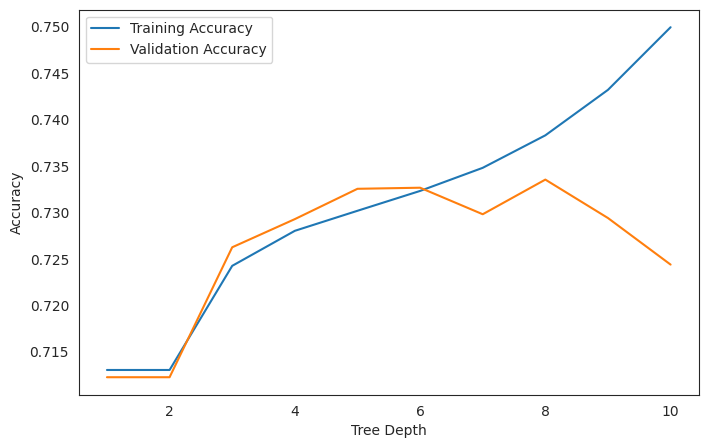

In [35]:
# Exploring the maximum depth of the tree
df = pd.DataFrame([tune_decision_tree(target_feature_value = i, 
                                      criterion = 'gini', 
                                      splitter  = 'best', 
                                      random_state = 41, 
                                      max_depth = i) for i in range(1, 11)],
                  columns = ['Tree Depth', 'Training Accuracy', 'Validation Accuracy'])

plot_model('Tree Depth')

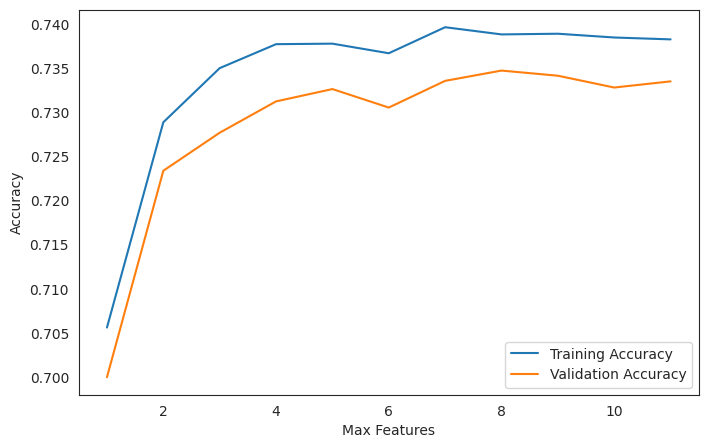

In [36]:
# Exploring the maximum number of features used in the decision tree
# Here I set the max_depth = 8
df = pd.DataFrame([tune_decision_tree(target_feature_value = i, 
                                      criterion = 'gini', 
                                      splitter  = 'best',
                                      max_depth = 8,
                                      max_features = i,
                                      random_state = 41) for i in range(1, 12)],
    columns = ['Max Features', 'Training Accuracy', 'Validation Accuracy'])

plot_model('Max Features')

Validation accuracy: 0.7347
Zero-One Loss: 0.2653
F1 Score: 0.725

Classification Report and Confusion Matrix
------------------------------------------
              precision    recall  f1-score   support

           0       0.73      0.76      0.74      8660
           1       0.75      0.71      0.72      8508

    accuracy                           0.73     17168
   macro avg       0.74      0.73      0.73     17168
weighted avg       0.74      0.73      0.73     17168



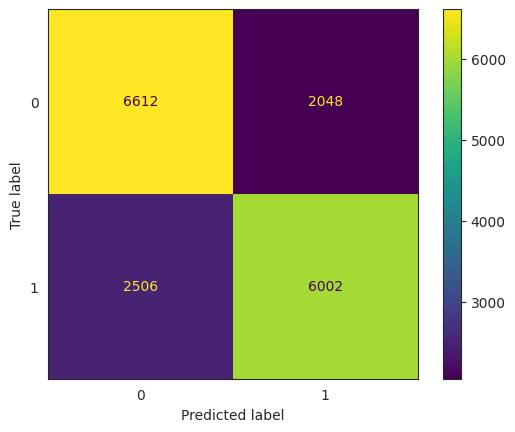

In [37]:
# After pruning 
final_dt_model = DecisionTreeClassifier(criterion = 'gini', splitter = 'best', max_depth = 8, max_features = 8, random_state = 41).fit(X_train, y_train)
val_pred = final_dt_model.predict(X_val)

print_and_append('DecisionTree', y_val, val_pred)
cr_and_cm(final_dt_model, y_val, val_pred)

In [38]:
base_df.iloc[:1, :]

,Model,Validation Accuracy,Zero-One Loss,F1 Score
0,DecisionTreeClassifier(random_state=41),0.6344,0.3656,0.6309


## Random Forest

In [39]:
def tune_random_forest(target_feature_value, **params):
  rf_model = RandomForestClassifier(**params).fit(X_train, y_train)
  train_pred = rf_model.predict(X_train)
  train_accuracy = accuracy_score(y_train, train_pred)

  val_pred = rf_model.predict(X_val)
  val_accuracy = accuracy_score(y_val, val_pred)

  return target_feature_value, train_accuracy, val_accuracy

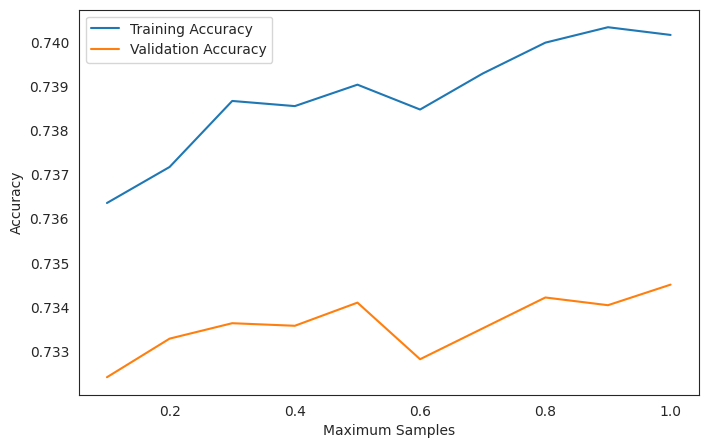

In [40]:
# Exploring the number of samples
df = pd.DataFrame([tune_random_forest(target_feature_value = i,
                                      criterion = 'gini',
                                      max_depth = 8,
                                      max_features = 'sqrt',
                                      max_samples = i,
                                      random_state = 41) for i in np.arange(0.1, 1.1, 0.1)], 
                  columns = ['Maximum Samples', 'Training Accuracy', 'Validation Accuracy'])

plot_model('Maximum Samples')

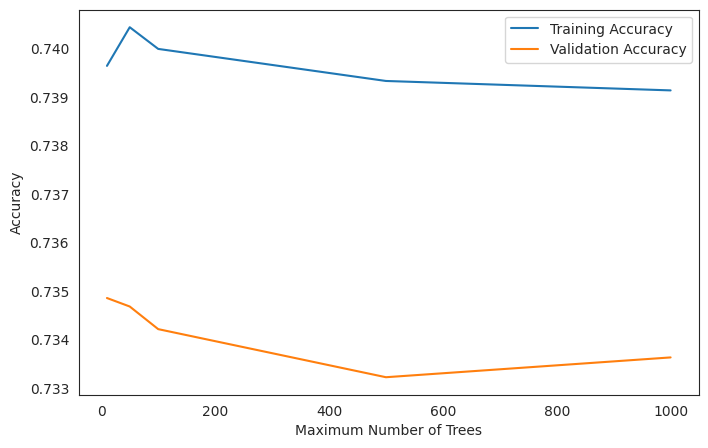

In [41]:
# Exploring the number of trees (n_estimators)
trees = [10, 50, 100, 500, 1000]
df = pd.DataFrame([tune_random_forest(target_feature_value = i,
                                      criterion = 'gini',
                                      max_depth = 8,
                                      max_features = 'sqrt',
                                      max_samples = 0.8,
                                      n_estimators = i,
                                      random_state = 41) for i in trees], 
                  columns = ['Maximum Number of Trees', 'Training Accuracy', 'Validation Accuracy'])

plot_model('Maximum Number of Trees')

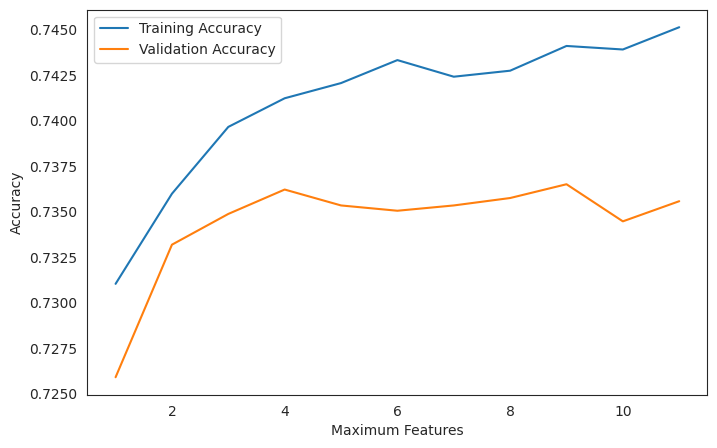

In [42]:
# Exploring the maximum number of features used in the decision tree
df = pd.DataFrame([tune_random_forest(target_feature_value = i,
                                      criterion = 'gini',
                                      max_depth = 8,
                                      max_features = i,
                                      max_samples = 0.8,
                                      n_estimators = 10,
                                      random_state = 41) for i in range(1, 12)], 
                  columns = ['Maximum Features', 'Training Accuracy', 'Validation Accuracy'])

plot_model('Maximum Features')

Validation accuracy: 0.7365
Zero-One Loss: 0.2635
F1 Score: 0.7228

Classification Report and Confusion Matrix
------------------------------------------
              precision    recall  f1-score   support

           0       0.72      0.78      0.75      8660
           1       0.76      0.69      0.72      8508

    accuracy                           0.74     17168
   macro avg       0.74      0.74      0.74     17168
weighted avg       0.74      0.74      0.74     17168



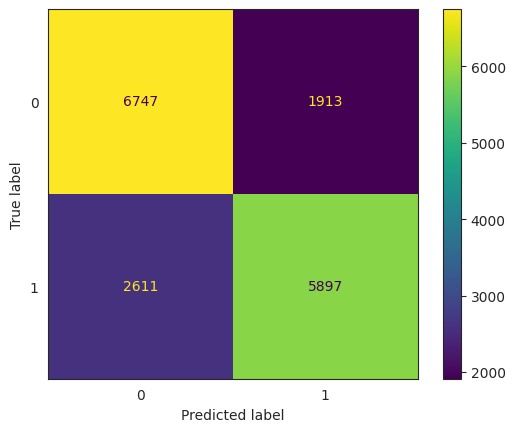

In [43]:
final_rf_model = RandomForestClassifier(criterion = 'gini', max_depth = 8, max_features = 9, max_samples = 0.8, 
                                        n_estimators = 10, random_state = 41).fit(X_train, y_train)
val_pred = final_rf_model.predict(X_val)

print_and_append('RandomForest', y_val, val_pred)
cr_and_cm(final_rf_model, y_val, val_pred)

In [44]:
base_df.iloc[1:2, :]

,Model,Validation Accuracy,Zero-One Loss,F1 Score
1,RandomForestClassifier(random_state=41),0.7164,0.2836,0.7101


## After Optimization

In [47]:
results_df

,Model,Validation Accuracy,Zero-One Loss,F1 Score
0,DecisionTree,0.7347,0.2653,0.7250
1,RandomForest,0.7365,0.2635,0.7228


After tuning all models, the results indicate that `RandomForest` outperforms the, but F1 score is higher in `DecisionTree`.